In [1]:
import tensorflow as tf

using_gpu_index = 0 # 使用的 GPU 号码
gpu_list = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(
        gpu_list[using_gpu_index],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 4)]
    )

2023-10-15 15:24:16.088263: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-15 15:24:16.092384: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-15 15:24:16.092486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
import cirq
import models.quantum_genotypes as genotypes

from models.quantum_models import generate_model_policy
from functools import reduce
env_name = "MountainCar-v0"

genotype = genotypes.ORI_TYPE_MC

n_qubits = 2  # Dimension of the state vectors in CartPole
# n_layers = 6  # Number of layers in the PQC
n_actions = 3  # Number of actions in CartPole

qubits = cirq.GridQubit.rect(1, n_qubits)
ops = [cirq.Z(q) for q in qubits]
observables = [cirq.Z(qubits[0]), reduce((lambda x, y: x * y), ops), cirq.Z(qubits[1])]  # Z_0*Z_1*Z_2*Z_3


# generate_model_policy(qubits, genotype, n_actions, beta, observables, env):
model = generate_model_policy(qubits, genotype, n_actions, 1.5, observables, env_name, using_H=True)

2023-10-15 15:24:16.851383: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-15 15:24:16.852306: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-15 15:24:16.852433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-15 15:24:16.852495: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

MountainCar-v0


In [3]:
from models.value_net import ValueNet

In [4]:
from IPython.core.display import HTML
from models.quantum_models import generate_circuit

circuit, params, inputs = generate_circuit(qubits, genotype, using_H=True)
display(HTML(f"<pre>{circuit}</pre>"))

In [5]:
from tensorflow.keras.optimizers import Adam

# hidden_dim = 64

# device = torch.device("cpu")

actor = model

critic = ValueNet()  # 价值网络
# 广义优势估计（Generalized Advantage Estimation，GAE）
# gamma 是GAE的超参数
gamma = 0.98

# lmbda 也用来计算广义优势估
lmbda = 0.95

epochs = 10  # 一条序列的数据用来训练轮数 4
# epochs = 4  # 一条序列的数据用来训练轮数 4
eps = 0.2  # 裁剪超参数
# actor_lr = 1e-3
critic_lr = 1e-2  # 结合 量子电路后 这个变得重要了起来
# critic_lr = 1e-1  # 结合 量子电路后 这个变得重要了起来
# critic_lr = 2.5e-4 #

# actor_optimizer = Adam(learning_rate=actor_lr)

# optimizer_in = Adam(learning_rate=0.01, amsgrad=True)
# optimizer_var = Adam(learning_rate=0.01, amsgrad=True)
# optimizer_out = Adam(learning_rate=0.1, amsgrad=True)

optimizer_in = Adam(learning_rate=0.01, epsilon=1e-5, amsgrad=False)
optimizer_var = Adam(learning_rate=0.01, epsilon=1e-5, amsgrad=False)
optimizer_out = Adam(learning_rate=0.1, epsilon=1e-5, amsgrad=False)

# Assign the model parameters to each optimizer
# w_in, w_var, w_out = 1, 0, 2

# critic_optimizer = Adam(learning_rate=critic_lr)
# critic_optimizer = Adam(learning_rate=critic_lr, amsgrad=True)  # 这个不知道 似乎作用有限
critic_optimizer = Adam(learning_rate=critic_lr, epsilon=1e-5, amsgrad=False)  # 全FALSE mountain car 可以收敛

In [6]:
from misc.utils import train
import numpy as np

state_ub = np.array([0.6, 0.07])
state_lb = np.array([-1.2, -0.07])

In [7]:
return_list = train(env_name, actor, critic, gamma, lmbda, eps, epochs,
          optimizer_in, optimizer_var, optimizer_out, critic_optimizer, -100.,
          critic_normalized=True, state_ub=state_ub, state_lb=state_lb, num_episodes=1000)

当前迭代次数为：0, 当前奖励为：-178.32790901395924, 平均奖励为：-178.32790901395924
当前迭代次数为：1, 当前奖励为：-179.61012625644625, 平均奖励为：-178.96901763520276
当前迭代次数为：2, 当前奖励为：-179.30537125589385, 平均奖励为：-179.08113550876647
当前迭代次数为：3, 当前奖励为：-179.69398306266683, 平均奖励为：-179.23434739724155
当前迭代次数为：4, 当前奖励为：-179.0052922705145, 平均奖励为：-179.18853637189613
当前迭代次数为：5, 当前奖励为：-179.21377819924123, 平均奖励为：-179.19274334312033
当前迭代次数为：6, 当前奖励为：-176.15915220964467, 平均奖励为：-178.75937318119523
当前迭代次数为：7, 当前奖励为：-173.44542814661054, 平均奖励为：-178.09513005187213
当前迭代次数为：8, 当前奖励为：-178.0384649595702, 平均奖励为：-178.08883393050525
当前迭代次数为：9, 当前奖励为：-175.81779674127733, 平均奖励为：-177.86173021158245
当前迭代次数为：10, 当前奖励为：-177.2126314249513, 平均奖励为：-177.75020245268166
当前迭代次数为：11, 当前奖励为：-173.0713578526864, 平均奖励为：-177.09632561230566
当前迭代次数为：12, 当前奖励为：-177.52512832324823, 平均奖励为：-176.91830131904112
当前迭代次数为：13, 当前奖励为：-176.8295040733827, 平均奖励为：-176.6318534201127
当前迭代次数为：14, 当前奖励为：-174.1553141396643, 平均奖励为：-176.1468556070277
当前迭代次数为：15, 当前奖励为：-175.17866011437337, 平均奖励

In [8]:
import pandas as pd

# 创建一个DataFrame对象
df = pd.DataFrame({'return_list': return_list})

# 将DataFrame保存到CSV文件
df.to_csv('../../../../results/example/ppo/ppo_quafu/all_state_normalize/return_list_MC', index=False)  # 可以指定文件名和是否包括行索引
actor.save_weights('../../../../weights/example/ppo/ppo_quafu/all_state_normalize/weights_MC_ACTOR_MC_amsgrad.h5')
critic.save_weights('../../../../weights/example/ppo/ppo_quafu/all_state_normalize/weights_MC_CRITIC_MC_amsgrad.h5')

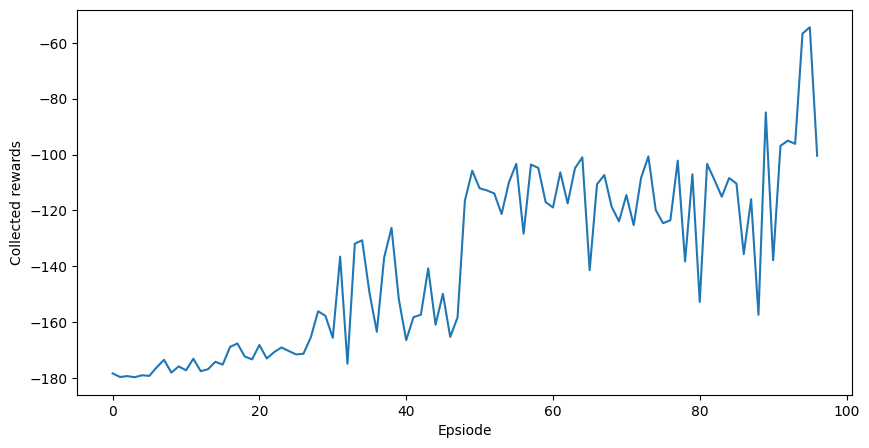

In [3]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(return_list)
plt.xlabel('Epsiode')
plt.ylabel('Collected rewards')
plt.show()